# 1D Bayesian Optimization with Thompson Sampling

This file demonstrates a sample Bayesian optimization loop for a toy 1D optimization problem.
It demonstrates Thompson Sampling as an acquisition function.

This demo is interactive. Download and run locally!

<a target="_blank" href="https://colab.research.google.com/github/gpleiss/gp_bo_demos/blob/main/1d_bo_ts_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import math
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display

# Maybe install requirements
try:
    import botorch
    import gpytorch
except ImportError:
    %pip install botorch
    import botorch
    import gpytorch

try:
    import ipympl  # For interactive widgets
except ImportError:
    %pip install ipympl
    import ipympl

# Allow for interactive widgets
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    %matplotlib widget
except ImportError:  # If we're not using google colab
    %matplotlib notebook

In [2]:
sigma = 0.01  # Noise


# Noiseless true function
def true_f(x):
    if x.dim() > 1:
        x = x[..., 0]
    x = x.add(2.5).div(6.)
    x = torch.stack([torch.ones_like(x), x, x.square(), x.pow(3)], dim=-1)
    coeffs = torch.tensor([-0.1486,  0.2930,  1.1478,  -1.0746], device=x.device, dtype=x.dtype)
    return 6 * (x @ coeffs.unsqueeze(-1)).squeeze(-1)


# Noisy true function
def noisy_f(x):
    f = true_f(x)
    noise = torch.randn_like(f).mul_(sigma)
    return f + noise

In [3]:
test_x = torch.linspace(-5, 5, 101)

In [4]:
def initial_training_data(seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    # Initialize with a random point
    i = (torch.rand(torch.Size([]), device=test_x.device) * len(test_x)).long().item()
    train_x = test_x[i].view(1, 1)
    train_y = noisy_f(train_x)
    return train_x, train_y


def evaluate_acq(num_samples, seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    with torch.no_grad():
        model.eval()
        acq = model(test_x).rsample(torch.Size([num_samples]))
    
    return acq


/Users/gpleiss/miniconda3/envs/playground/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/Users/gpleiss/miniconda3/envs/playground/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/gpleiss/miniconda3/envs/playground/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([1.5602]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning

Button(description='Reset', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

<IPython.core.display.Javascript object>


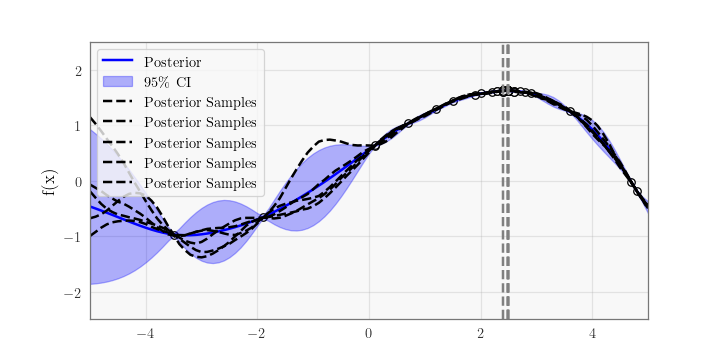

interactive(children=(IntSlider(value=1, description='Num. Samples', max=5, min=1), Output()), _dom_classes=('…

/Users/gpleiss/miniconda3/envs/playground/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/gpleiss/miniconda3/envs/playground/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [5]:
train_x, train_y = initial_training_data()
i = 0

# Construct surrogate model
kernel_function = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
kernel_function.base_kernel.initialize(lengthscale=1.5)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.initialize(noise=(sigma ** 2))
model = botorch.models.SingleTaskGP(
    train_x, train_y.unsqueeze(-1),
    covar_module=kernel_function, likelihood=likelihood,
)

# Expected improvement module


clearbutton = widgets.Button(description="Reset")
display(clearbutton)
nextbutton = widgets.Button(description="Next")
display(nextbutton)
num_samples_slider = widgets.IntSlider(description=r"Num. Samples", value=1, min=1, max=5, step=1)

fig, f_ax = plt.subplots(1, 1, figsize=(8, 4))
f_ax.set_xlim(test_x.min().item(), test_x.max().item())
f_ax.set_ylim(-2, 2)
f_ax.set_xlabel('x')
f_ax.set_ylabel('y')


def clear_plot(event):
    global train_x, train_y, i
    
    train_x, train_y = initial_training_data()
    model.set_train_data(train_x, train_y, strict=False)
    update_plot(num_samples=num_samples_slider.value)


def update_plot(num_samples=0.95):
    global i
    f_ax.clear()
    
    # Compute predictive posterior
    plot_prior = train_x.numel() == 0  # We'll simply plot the GP prior when there's no data
    with torch.no_grad(), gpytorch.settings.prior_mode(plot_prior):
        model.eval()
        prediction = model(test_x)
        mean = prediction.mean
        lower, upper = prediction.confidence_region()

    # Plot predictive posterior
    f_ax.scatter(train_x, train_y, marker='o', edgecolors='k', color='white')
    mean_line, = f_ax.plot(test_x.numpy(), mean.numpy(), color='b', label="Posterior")
    f_ax.fill_between(
        test_x.numpy(), lower.numpy(), upper.numpy(),
        color=mean_line.get_color(), alpha=0.3, label="95\% CI"
    )
    acq = evaluate_acq(num_samples=num_samples)
    f_ax.plot(test_x, acq.T, "k--", label="Posterior Sample")
    f_ax.set(xlim=[-5., 5.], ylim=[-2.5, 2.5], ylabel="f(x)")
    f_ax.legend(loc="best")
    
    # Plot maximizing x
    i = acq.argmax(dim=-1)
    for sub_i in i.tolist():
        f_ax.axvline(test_x[sub_i].item(), ls="--", color="gray", lw=2)

    
def acquire_next_point(event):
    global train_x, train_y, test_x, i

    new_x = test_x[i].view(-1, 1)
    new_y = noisy_f(new_x)
    train_x = torch.cat([train_x, new_x], dim=-2)
    train_y = torch.cat([train_y, new_y], dim=-1)
    
    model.set_train_data(train_x, train_y, strict=False)
    update_plot(num_samples=num_samples_slider.value)


clearbutton.on_click(clear_plot)
nextbutton.on_click(acquire_next_point)
interact(update_plot, num_samples=num_samples_slider)
update_plot(num_samples=num_samples_slider.value)